In [1]:
%load_ext autoreload
%autoreload 2


from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import IPython
import tensorflow as tf

import prepare_data
import training
import utils
import models
import gin

gin.parse_config_file('config/default.gin')
gin.enter_interactive_mode()

fft_length = gin.query_parameter('%fft_length')
frame_length = gin.query_parameter('%frame_length')
frame_step = gin.query_parameter('%frame_step')
sample_rate = gin.query_parameter('%sample_rate')

Metal device set to: Apple M1 Pro


2022-05-16 12:41:27.502921: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-16 12:41:27.503057: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2022-05-16 12:54:25.001192: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


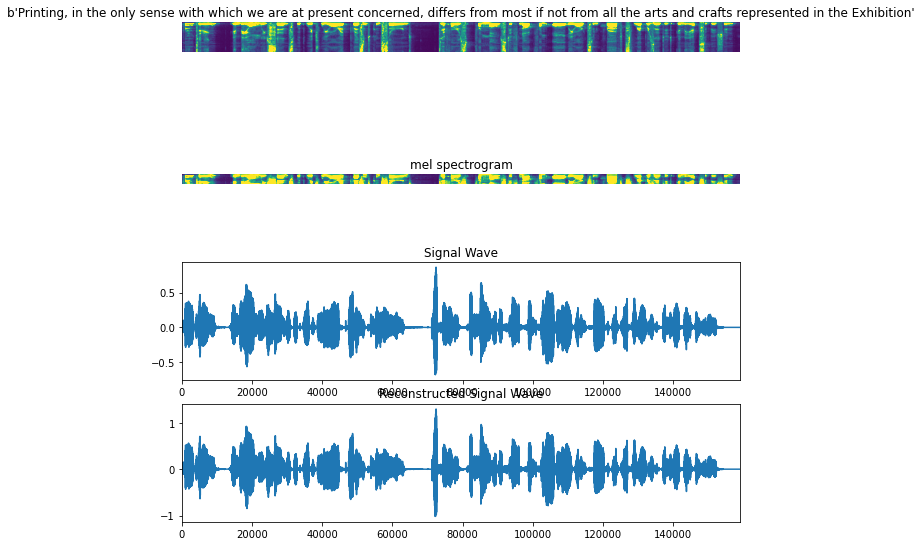

In [4]:
#train_dataset, _ = prepare_data.datasets(target_sample_rate=sample_rate, keep_audio=True, keep_raw_spectrogram=True, keep_transcription=True)
train_dataset, _ = prepare_data.datasets(keep_audio=True, keep_raw_spectrogram=True, keep_transcription=True)

fig = plt.figure(figsize=(10, 10))
for batch in train_dataset.take(1):
    spectrogram, mel_spec, enc_transcription, audio, raw_spectrogram, transcription = (col[0].numpy() for col in batch)
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    mel_spec = np.array([np.trim_zeros(x) for x in np.transpose(mel_spec)])

    ax = plt.subplot(4, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(transcription)
    ax.axis("off")


    ax = plt.subplot(4, 1, 2)
    ax.imshow(mel_spec, vmax=1)
    ax.set_title('mel spectrogram')
    ax.axis("off")

    ax = plt.subplot(4, 1, 3)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    
    rec_audio = tf.signal.inverse_stft(
        raw_spectrogram,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=fft_length
    )

    ax = plt.subplot(4, 1, 4)
    plt.plot(rec_audio)
    ax.set_title("Reconstructed Signal Wave")
    ax.set_xlim(0, len(rec_audio))
        

    IPython.display.display(IPython.display.Audio(np.transpose(audio), rate=sample_rate))
    IPython.display.display(IPython.display.Audio(np.transpose(rec_audio), rate=sample_rate))

    
    
plt.show()


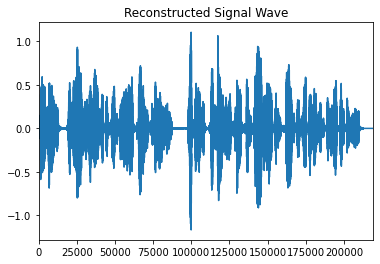

In [9]:
reconstructed_audio = utils.griffin_lim(tf.abs(raw_spectrogram), fft_length, frame_step, 50)

ax = plt.subplot(1, 1, 1)
plt.plot(reconstructed_audio)
ax.set_title("Reconstructed Signal Wave")
ax.set_xlim(0, len(reconstructed_audio))
plt.show()

IPython.display.display(IPython.display.Audio(np.transpose(reconstructed_audio), rate=sample_rate))

In [46]:
naiveLstmTTS = models.NaiveLstmTTS()
naiveLstmTTS.model.set_weights(tf.keras.models.load_model('models/20220512-015911').get_weights())

In [47]:
# Extremely slow at the moment

new_mel_spec = naiveLstmTTS.decode_mel_spec(tf.expand_dims(enc_transcription, 0), 300) # 3320)

2022-05-12 02:00:19.674144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 02:00:19.720245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 02:00:19.969970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 02:00:20.011276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


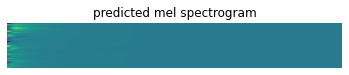

In [48]:
ax = plt.subplot(1, 1, 1)
ax.imshow(np.transpose(new_mel_spec[0]), vmax=1)
ax.set_title('predicted mel spectrogram')
ax.axis("off")
plt.show()

In [49]:
new_mel_spec

<tf.Tensor: shape=(1, 300, 40), dtype=float32, numpy=
array([[[-5.5393994e-01,  4.5959762e-01, -5.4719068e-02, ...,
          1.0785705e-01,  2.2604199e-01,  3.7913865e-01],
        [-5.6306297e-01,  4.1079679e-01, -1.0387235e-01, ...,
          4.5918792e-02,  2.8062415e-01,  3.8997617e-01],
        [-4.3214098e-01,  3.7647384e-01, -2.8043142e-02, ...,
          1.4236282e-01,  2.2532168e-01,  3.5900378e-01],
        ...,
        [-3.6177225e-05,  2.5214627e-05, -3.9253384e-05, ...,
          3.6069192e-05,  6.4653344e-05, -2.2298656e-05],
        [-3.6265701e-05,  2.4659559e-05, -3.9858744e-05, ...,
          3.5687350e-05,  6.4185821e-05, -2.2816472e-05],
        [-3.6330894e-05,  2.4095178e-05, -4.0431507e-05, ...,
          3.5298523e-05,  6.3749962e-05, -2.3342203e-05]]], dtype=float32)>

In [52]:
mel_spec.shape

(40, 651)